<a href="https://colab.research.google.com/github/Doppler-67/sentiment_analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
#!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
#!cp mystem /root/.local/bin/mystem

In [2]:
#!pip install transformers

**Цель проекта:**

Нужно построить модель, которая будет определять токсичность текста.

**Описание данных:**

В качестве данных был взят корпус русскоязычных твитов RuTweetCorp.

⭕ Более подробная информация находится в README файле.

# **Importing libraries**

In [3]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import nltk
import re
import transformers
import matplotlib.pyplot as plt

from tqdm import notebook

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from pymystem3 import Mystem 

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
sns.set()

# **Data understanding**

In [6]:
col_names = ['id', 'tdate', 'tmane', 'text', 'toxic', 'trep', 'trtw', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount']

In [7]:
pos_data = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/positive.csv', sep=';', header=None, names=col_names)
neg_data = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/negative.csv', sep=';', header=None, names=col_names)

In [8]:
pos_data.head()

,id,tdate,tmane,text,toxic,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [9]:
neg_data.head()

,id,tdate,tmane,text,toxic,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


# **Data preparation**

In [10]:
neg_data['toxic'] = 0

Соединим все один датасет.

In [11]:
data = pd.concat([pos_data, neg_data])

In [12]:
data.head()

,id,tdate,tmane,text,toxic,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


Отбросим ненужные колонки.

In [13]:
data = data[['text', 'toxic']]

In [14]:
data['toxic'] = data['toxic'].astype(bool)

Теперь очистим корпус от лишних символов.

In [15]:
def clear_text(text):
    t = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text)
    t = ' '.join(t.split())
    return t

In [16]:
data['clear_text'] = data['text'].apply(clear_text)

In [17]:
data = data.sample(frac=1).reset_index(drop=True)

In [18]:
data.head()

,text,toxic,clear_text
0,#ВзаимныйФолловинг #ЧитаюВзаимно #ЧитайМеняАяТ...,True,ВзаимныйФолловинг ЧитаюВзаимно ЧитайМеняАяТебя...
1,-Купи слона...! По-любому родители слышали это...,True,Купи слона По любому родители слышали это от вас
2,"Все спят походу, одна я в такую рань уроки дел...",False,Все спят походу одна я в такую рань уроки делаю
3,@DarrenCrissNA бедняяжечка(( ты кстати потом п...,False,бедняяжечка ты кстати потом пойдешь в магистра...
4,"Наступает время для сна,но не для меня;-) http...",True,Наступает время для сна но не для меня


In [19]:
data = data.head(2300) # !!!

# **EDA**

Изучим кол-во символов и слов в текстах.

In [20]:
data['symbols'] = data['clear_text'].apply(len)
data['tokens'] = data['clear_text'].str.split().apply(len)


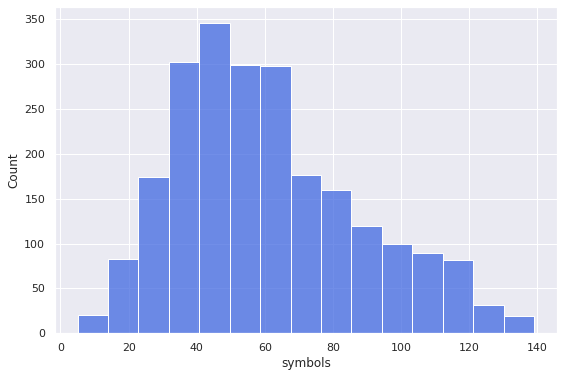

In [21]:
plt.figure(figsize=(9, 6))
sns.histplot(x=data['symbols'], color='royalblue', bins=15)
plt.show()

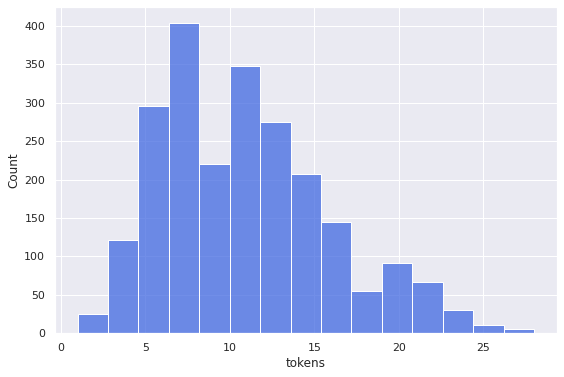

In [22]:
plt.figure(figsize=(9, 6))
sns.histplot(x=data['tokens'], color='royalblue', bins=15)
plt.show()

Изучим таргет.

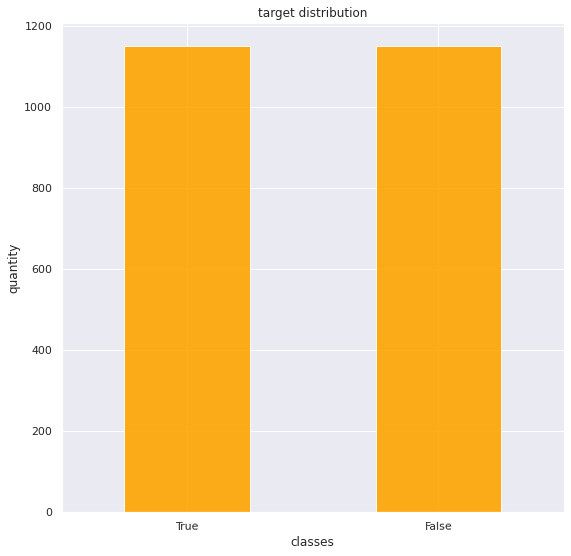

In [23]:
data['toxic'].value_counts().plot(kind='bar', title='target distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(9,9))
plt.show()

в таргете классы сбалансированы.

Попробуем два подхода:
1. TF-IDF.
2. эмбеддинги, сгенерированные с помощью ruBERT.

# **TF-IDF**

In [24]:
m = Mystem()

In [25]:
def lemmatize_text(text):
    tokens = m.lemmatize(text.lower())
    tokens = [token for token in tokens if token != '\n']
    text = " ".join(tokens)
    
    return text

In [26]:
data['lemm_text'] = data['clear_text'].apply(lemmatize_text)

In [27]:
data.head()

,text,toxic,clear_text,symbols,tokens,lemm_text
0,#ВзаимныйФолловинг #ЧитаюВзаимно #ЧитайМеняАяТ...,True,ВзаимныйФолловинг ЧитаюВзаимно ЧитайМеняАяТебя...,59,5,взаимныйфолловинг читаювзаимно читайменяая...
1,-Купи слона...! По-любому родители слышали это...,True,Купи слона По любому родители слышали это от вас,48,9,купить слон по любой родитель слышат...
2,"Все спят походу, одна я в такую рань уроки дел...",False,Все спят походу одна я в такую рань уроки делаю,47,10,все спать поход один я в такой р...
3,@DarrenCrissNA бедняяжечка(( ты кстати потом п...,False,бедняяжечка ты кстати потом пойдешь в магистра...,103,16,бедняяжечка ты кстати потом пойти в ...
4,"Наступает время для сна,но не для меня;-) http...",True,Наступает время для сна но не для меня,38,8,наступать время для сон но не для я


In [28]:
nltk.download('stopwords')
stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
x_train, x_test, y_train, y_test = train_test_split(data['lemm_text'], data['toxic'], train_size=0.8, random_state=67)

In [30]:
train_corpus = x_train.values.astype('U')
test_corpus = x_test.values.astype('U')

In [31]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [32]:
train_tf_idf = count_tf_idf.fit_transform(x_train)
test_tf_idf = count_tf_idf.transform(x_test)

In [33]:
train_tf_idf.shape, test_tf_idf.shape

((1840, 4619), (460, 4619))

In [34]:
model = LogisticRegression(max_iter=10000, random_state=67)

In [35]:
scores = cross_val_score(model, train_tf_idf, y_train, cv=5, scoring='roc_auc')
print(scores)
print('avg auc-roc:', sum(scores) / len(scores))

[0.68359329 0.66572138 0.68551341 0.67322404 0.65801211]
avg auc-roc: 0.6732128458675259


In [36]:
log_reg_params = {
    'C': [10 ** -2, 10 ** -1, 1, 10, 10 ** 2], 
    'solver' : ['lbfgs', 'liblinear']
    }

In [37]:
clf = GridSearchCV(model, log_reg_params, scoring='roc_auc')
clf.fit(train_tf_idf, y_train)
clf.best_params_

{'C': 1, 'solver': 'liblinear'}

In [38]:
model = clf.best_estimator_
model.fit(train_tf_idf, y_train)

LogisticRegression(C=1, max_iter=10000, random_state=67, solver='liblinear')

Напишем фунцию для удобного построения графика AUC-ROC.

In [39]:
def display_auc_roc(model, x, y):
  probs = model.predict_proba(x)
  preds = probs[:,1]
  fpr, tpr, threshold = roc_curve(y, preds)
  roc_auc = auc(fpr, tpr)

  plt.title('ROC')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

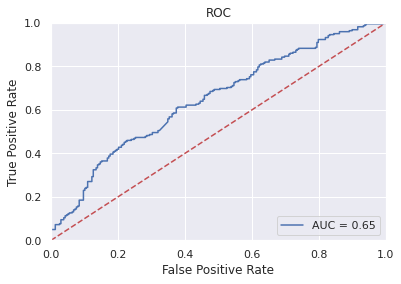

In [40]:
display_auc_roc(model, test_tf_idf, y_test)

In [41]:
#stop

# **ruBERT**

In [42]:
tokenizer = transformers.BertTokenizer('/content/drive/MyDrive/sentiment_analysis/vocab.txt')

In [43]:
tokenized = data['clear_text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

In [44]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

In [45]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

In [46]:
config = transformers.BertConfig.from_json_file(
    '/content/drive/MyDrive/sentiment_analysis/bert_config.json')
model = transformers.BertModel.from_pretrained(
    '/content/drive/MyDrive/sentiment_analysis/rubert_model.bin', config=config)

Some weights of the model checkpoint at /content/drive/MyDrive/sentiment_analysis/rubert_model.bin were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/23 [00:00<?, ?it/s]

In [48]:
features = np.concatenate(embeddings)

In [49]:
x_train, x_test, y_train, y_test = train_test_split(features, data['toxic'], train_size=0.8, random_state=67)

In [50]:
model = LogisticRegression(max_iter=10000, random_state=67)

In [51]:
scores = cross_val_score(model, train_tf_idf, y_train, cv=5, scoring='roc_auc')
print(scores)
print('avg auc-roc:', sum(scores) / len(scores))

[0.68359329 0.66572138 0.68551341 0.67322404 0.65801211]
avg auc-roc: 0.6732128458675259


In [52]:
clf = GridSearchCV(model, log_reg_params, scoring='roc_auc')
clf.fit(x_train, y_train)
clf.best_params_

{'C': 0.01, 'solver': 'liblinear'}

In [55]:
model = clf.best_estimator_
model.fit(x_train, y_train)

LogisticRegression(C=0.01, max_iter=10000, random_state=67, solver='liblinear')

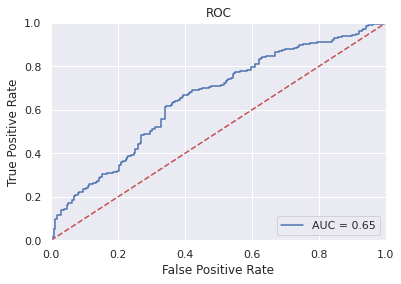

In [56]:
display_auc_roc(model, x_test, y_test)

# **Results**